## Simple benchmark tests for IoT models.


Data:

Assume there is a true cost function $C$ and true marginals $\mu$ and $\nu$

Generate a transport plan for this cost function.
Sample from the marginals with replacement
Sample from the transport plan with replacement

log likelihood contributions:

    * dirichlet prior for mu, nu    
    * some prior for C.
    * write down log-posterior....

blackjax sampler


In [3]:
import jax
import jax.numpy as jnp
import jax.random as random
from jax.config import config
config.update("jax_enable_x64", True)

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

key = random.PRNGKey(0)


# A simple example of solving regularised entropy OT problems using Sinkhorn in jax-ott.

In [4]:
M, N = 10, 12   # nu is M-dimensional, mu is N-dimensional

# define "true" marginals
mu = jnp.ones(M) / M # uniform marginal

nu = jnp.array([i**2 for i in range(1, N+1)]) 
nu = nu / jnp.sum(nu) 


In [5]:
# define "true" cost
iota = 1e-6
C = jnp.array([[iota + (i - j)**2 for j in range(N)] for i in range(M)], dtype=jnp.float64)

# normalize cost
C = C/C.sum(axis=0, keepdims=True)

Text(0.5, 1.0, 'nu')

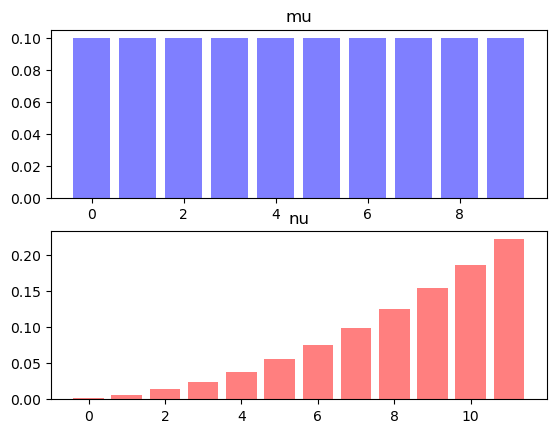

In [6]:
# plot the marginals
fig, axs = plt.subplots(2)
axs[0].bar(range(M), mu, color='blue', alpha=0.5)
axs[0].set_title('mu')

axs[1].bar(range(N), nu, color='red', alpha=0.5)
axs[1].set_title('nu')


In [7]:
import ott
from ott.geometry.geometry import Geometry
from ott.solvers.linear import sinkhorn

def ott_sinkhorn(mu, nu, C, epsilon):
    """Sinkhorn algorithm using OTT"""
    
    # define the geometry
    geom = Geometry(cost_matrix=C)

    # define the solver
    out = sinkhorn.solve(geom, a=mu, b=nu)

    return out.matrix, out.reg_ot_cost


/Users/aduncan/opt/anaconda3/envs/iot/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/Users/aduncan/opt/anaconda3/envs/iot/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)


Text(0.5, 1.0, 'recovered marginal 2')

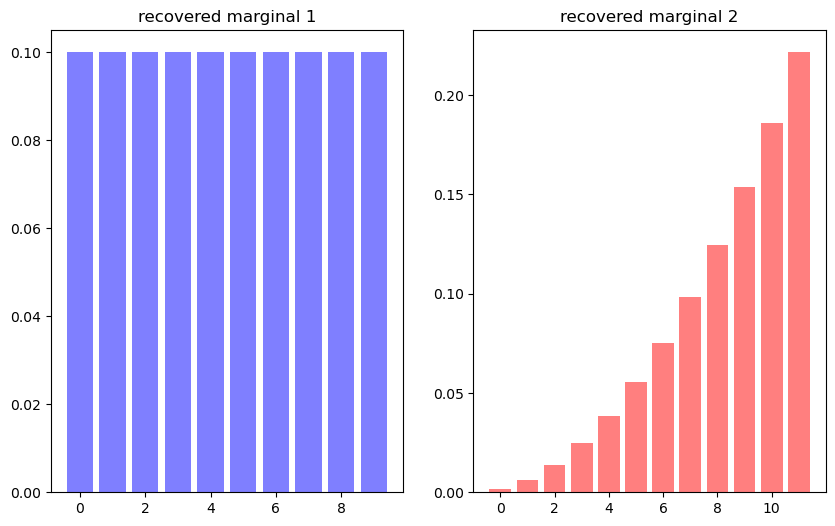

In [8]:
ot_matrix, ot_cost = ott_sinkhorn(mu, nu, C, 0.05)

# plot the marginals
fig, axs = plt.subplots(1,2, figsize=(10, 6))
axs[0].bar(range(M), ot_matrix.sum(axis=1), color='blue', alpha=0.5)
axs[0].set_title('recovered marginal 1')

axs[1].bar(range(N), ot_matrix.sum(axis=0), color='red', alpha=0.5)
axs[1].set_title('recovered marginal 2')


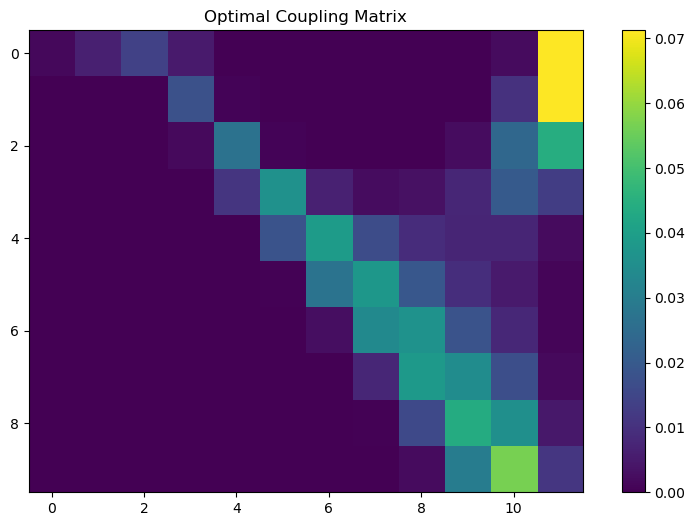

Regularised OT cost 0.072584


In [9]:
plt.figure(figsize=(10, 6))
plt.imshow(ot_matrix)
plt.colorbar()
plt.title("Optimal Coupling Matrix")
plt.show()

print("Regularised OT cost %f"%(ot_cost))

# Autodifferentiation of the Sinkhorn function.

Here we experiment using JAX to autodiff our way through the solution of the regularised OT problem.

Ultimately we will require to compute gradients of a scalar valued function (log-posterior) with respect to $\mu$, $\nu$ and $C$.

In [10]:
def reg_OT_cost(mu: jnp.ndarray, nu: jnp.ndarray, C : jnp.ndarray) -> float:
    return sinkhorn.solve(Geometry(cost_matrix=C), a=mu, b=nu).reg_ot_cost
    

In [11]:
# Note that by default, JAX only computes the gradient w.r.t the first of variable
r_ot = jax.value_and_grad(reg_OT_cost)

cost, full_grad = r_ot(mu, nu, C)

full_grad.shape

(10,)

In [12]:
# To take a gradient with respect to the other variables, we need to specify the argnum
r_ot = jax.value_and_grad(reg_OT_cost, argnums=(0,1))

cost, full_grad = r_ot(mu, nu, C)
grad_mu, grad_nu = full_grad

print(grad_mu.shape, grad_nu.shape)


(10,) (12,)


In [13]:
# Now let's do it including the cost function
r_ot = jax.value_and_grad(reg_OT_cost, argnums=(0,1, 2))

cost, full_grad = r_ot(mu, nu, C)
grad_mu, grad_nu, grad_C = full_grad

print(grad_mu.shape, grad_nu.shape, grad_C.shape)


(10,) (12,) (10, 12)


# The OT inverse problem

Now let's consider the problem of recovering the cost from noisy observations of the transport plan and/or marginals



In [32]:
import numpyro
from numpyro.infer import MCMC, NUTS
from numpyro.distributions import Uniform, Dirichlet, Multinomial
import os

## Case 1: Perfectly observed marginals

In this setting, we assume that we observe the marginals perfectly, and make noisy, independent observations of the transport map.

In [102]:
T =  sinkhorn.solve(Geometry(cost_matrix=C), a=mu, b=nu).matrix

# generate observations
num_obs = 100
T_obs = np.random.multinomial(num_obs, T.reshape(M*N))

In [105]:
def model(data=None):

    mu_ = numpyro.sample("mu_", Dirichlet(jnp.ones(M)))
    nu_ = numpyro.sample("nu_", Dirichlet(jnp.ones(N)))

    C_ = numpyro.sample("cost", Uniform(0., 1.), sample_shape=(M, N)) 
    T =  sinkhorn.solve(Geometry(cost_matrix=C_), a=mu_, b=nu_).matrix


    numpyro.sample("Z", Multinomial(probs=T.reshape(M*N)), obs=data)

In [106]:
key, mcmc_key = random.split(key)

mcmc = MCMC(
        NUTS(model, dense_mass=True),
        num_warmup=100,
        num_samples=1000,
        num_chains=1,
        progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True,
)

mcmc.run(mcmc_key,  data=T_obs)
mcmc.print_summary()

sample: 100%|██████████| 1100/1100 [11:44<00:00,  1.56it/s, 1023 steps of size 2.52e-28. acc. prob=0.84] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
    mu_[0]      0.06      0.00      0.06      0.06      0.06      0.50      1.00
    mu_[1]      0.21      0.00      0.21      0.21      0.21      0.50      1.00
    mu_[2]      0.02      0.00      0.02      0.02      0.02      0.50      1.00
    mu_[3]      0.38      0.00      0.38      0.38      0.38      0.50      1.00
    mu_[4]      0.10      0.00      0.10      0.10      0.10      0.50      1.00
    mu_[5]      0.01      0.00      0.01      0.01      0.01      0.50      1.00
    mu_[6]      0.11      0.00      0.11      0.11      0.11      0.50      1.00
    mu_[7]      0.04      0.00      0.04      0.04      0.04      0.50      1.00
    mu_[8]      0.06      0.00      0.06      0.06      0.06      0.50      1.00
    mu_[9]      0.01      0.00      0.01      0.01      0.01      0.50      1.00
    nu_[0]      0.11      0.00      0.11      0.11      0.11      0.50      1.00
    nu_[1]      0.15      0

Text(0.5, 1.0, 'The nu marginal')

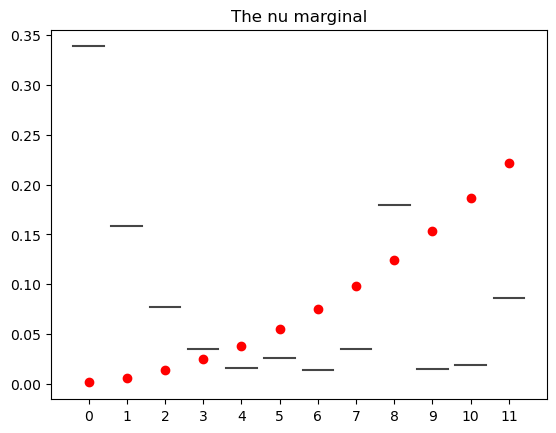

In [98]:
import seaborn as sns

samples_1 = mcmc.get_samples()
nu_post = samples_1['nu_']
sns.violinplot(data=nu_post)
plt.plot(range(nu_post.shape[1]), nu, 'o', color='red')
plt.title("The nu marginal")

Text(0.5, 1.0, 'The mu marginal')

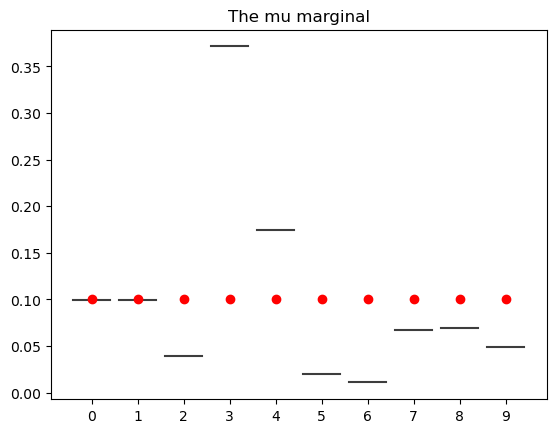

In [99]:
import seaborn as sns

samples_1 = mcmc.get_samples()
mu_post = samples_1['mu_']
sns.violinplot(data=mu_post)
plt.plot(range(mu_post.shape[1]), mu, 'o', color='red')
plt.title("The mu marginal")

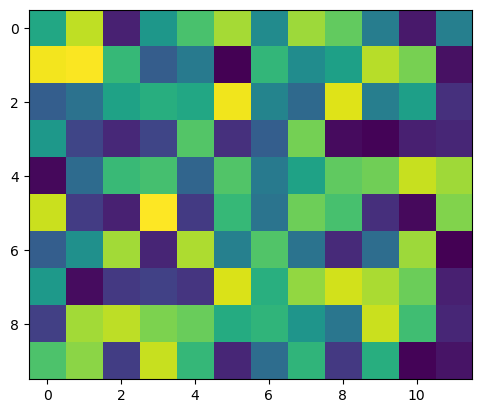

In [84]:
plt.imshow(samples_1['cost'].mean(axis=0))

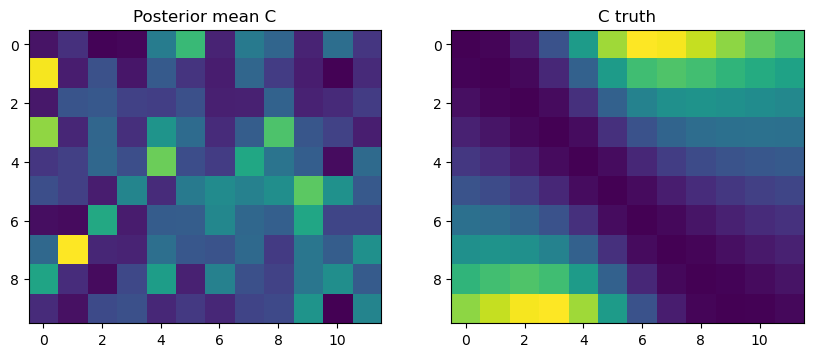

In [32]:
fig, axs = plt.subplots(1,2, figsize=(10, 6))

axs[0].set_title('Posterior mean C')
axs[0].imshow(C_samples.mean(axis=0))

axs[1].set_title('C truth')
axs[1].imshow(C)